On this project we shall explore a Kickstarter dataset of 51 files with 20 MB each talking about different projects related to it, first lets install a package i created and you can find in this repository

In [1]:
devtools::install_github("R-S-P-MODELS/cleanerR/cleanerR")
require(cleanerR)
require(ggplot2)
require(data.table)

Skipping install of 'cleanerR' from a github remote, the SHA1 (842f117e) has not changed since last install.
  Use `force = TRUE` to force installation
Loading required package: cleanerR
Loading required package: ggplot2
Loading required package: data.table


Now to load the dataset

In [2]:
setwd("~/Transferências/Kickstarter_2018-09-13T03_20_17_777Z/")
files=list.files(pattern="*.csv")
Kickstarter_list=lapply(files,fread)
Kickstarter=data.frame()
for(i in 1:length(Kickstarter_list)){
    Kickstarter=rbind(Kickstarter,Kickstarter_list[[i]])
}
rm(Kickstarter_list)

Now we have the dataset loaded we could explore it, first lets check its dimension and the names of the collumns, as well as their class

In [3]:
cat(" The dimension of the Kickstarter dataset is:",dim(Kickstarter),"\n")
print("The names of the collumns are:")
print(names(Kickstarter))
print("And the class of each collumn is the following:")
print(sapply(Kickstarter,class))

 The dimension of the Kickstarter dataset is: 205091 37 
[1] "The names of the collumns are:"
 [1] "backers_count"            "blurb"                   
 [3] "category"                 "converted_pledged_amount"
 [5] "country"                  "created_at"              
 [7] "creator"                  "currency"                
 [9] "currency_symbol"          "currency_trailing_code"  
[11] "current_currency"         "deadline"                
[13] "disable_communication"    "friends"                 
[15] "fx_rate"                  "goal"                    
[17] "id"                       "is_backing"              
[19] "is_starrable"             "is_starred"              
[21] "launched_at"              "location"                
[23] "name"                     "permissions"             
[25] "photo"                    "pledged"                 
[27] "profile"                  "slug"                    
[29] "source_url"               "spotlight"               
[31] "staff_pick"    

We could first check from which countries these projects came from, as well as their distribution, so lets do it

In [4]:
cat("The countries of the dataset are:",unique(Kickstarter$country))

The countries of the dataset are: US GB IT DE CA ES MX NL SE FR AU HK NO NZ JP DK AT IE CH BE SG LU

And their distribution is:

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

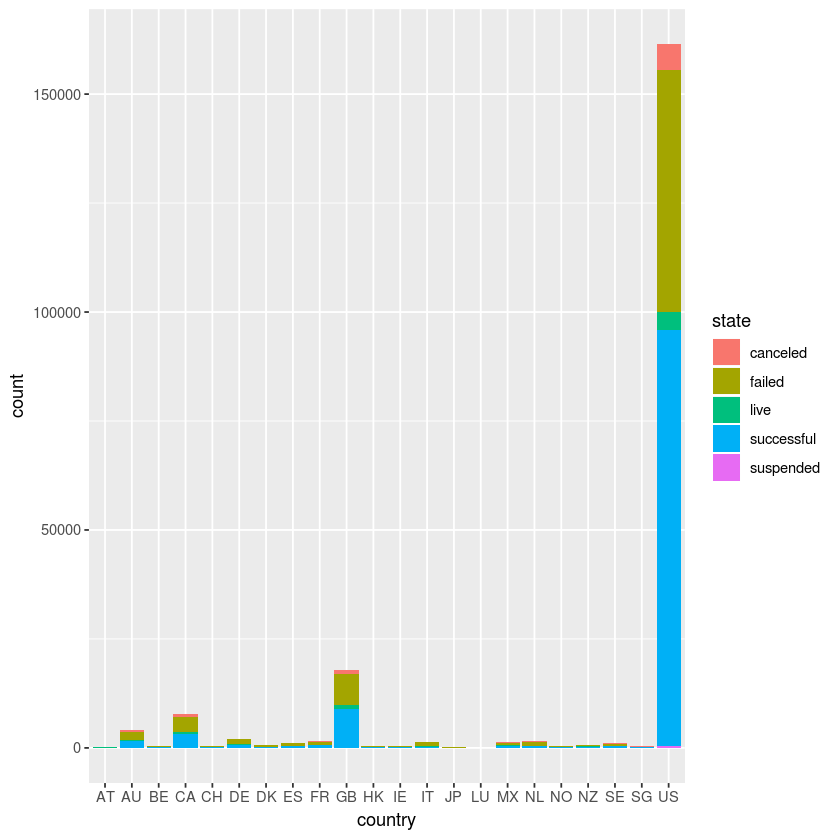

In [5]:
cat("And their distribution is:")
ggplot(data=Kickstarter) +geom_histogram(aes(x=country,fill=state),stat="count") 

Here i decided to put state of the project as a color, this graph tells us 2 things
First the dataset is imbalanced having more US data in the attribute country
Second the dataset is also imbalanced having more successful projects than the rest combined

Since it is already expected that as more backers give money the project will have more money on converted_pledged amount we could then test for the ratio of converted pledged amount to goal

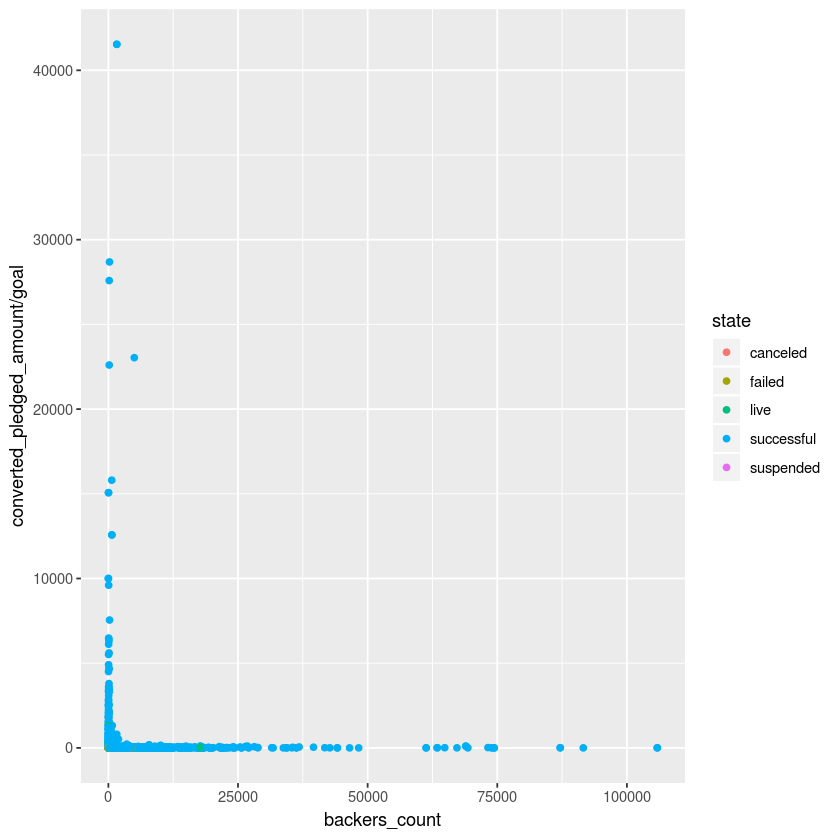

In [6]:
ggplot(data=Kickstarter) +geom_point(aes(x=backers_count,y=converted_pledged_amount/goal  ,color=state)) 

We can see this graph does not behave well backers count are very low, so lets take a look at it from 10000 backers foward

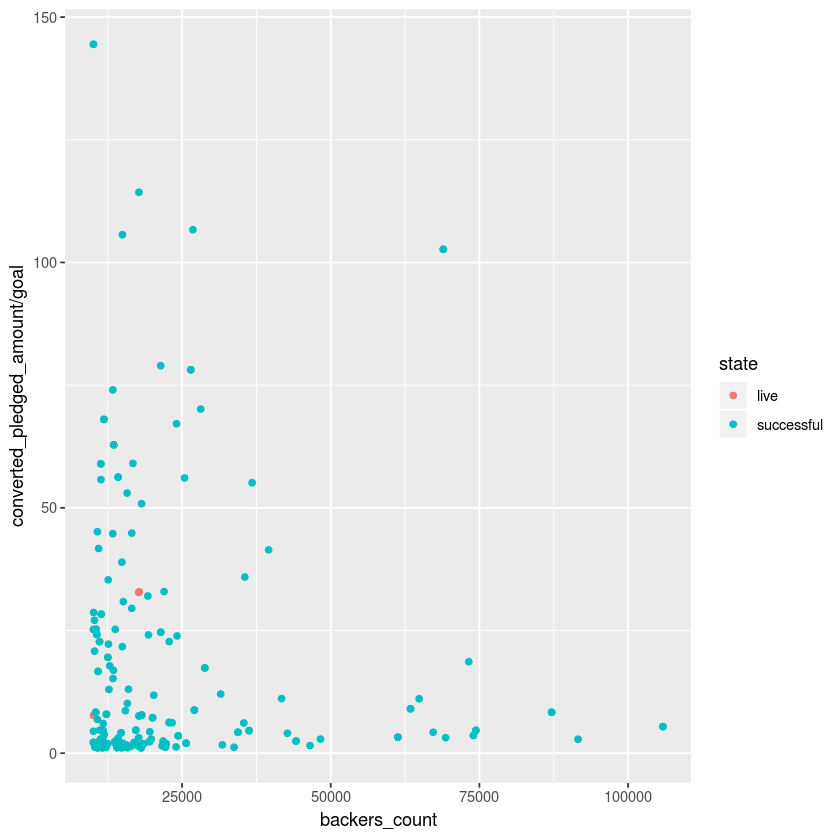

In [7]:
Kick1e4=Kickstarter[which(Kickstarter$backers_count>1e4),]
ggplot(data=Kick1e4) +geom_point(aes(x=backers_count,y=converted_pledged_amount/goal  ,color=state)) 

In this case we can see all projects with at least 10 thousand backers were sucessful or were still live, now to check the other part

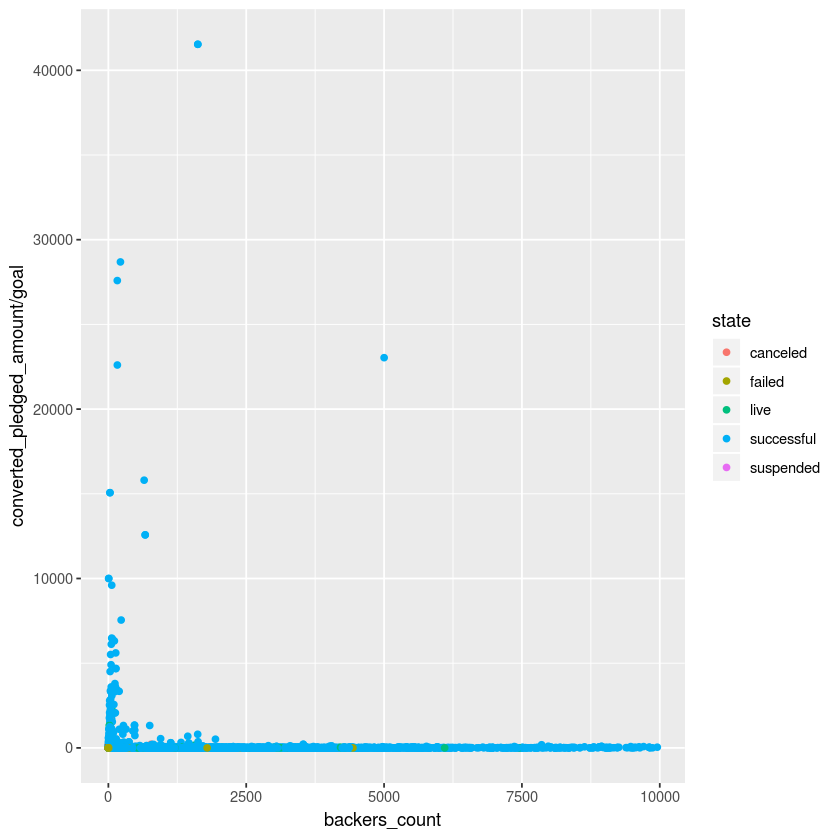

In [8]:
Kick1e4=Kickstarter[which(Kickstarter$backers_count<1e4),]
ggplot(data=Kick1e4) +geom_point(aes(x=backers_count,y=converted_pledged_amount/goal  ,color=state)) 

We could then wonder if there are multiple projects by the same creator during this time period to ask so we do the following command


     1      2      3      4      5      6      7      8     10 
203017    933     30     15      4      1      2      1      1 


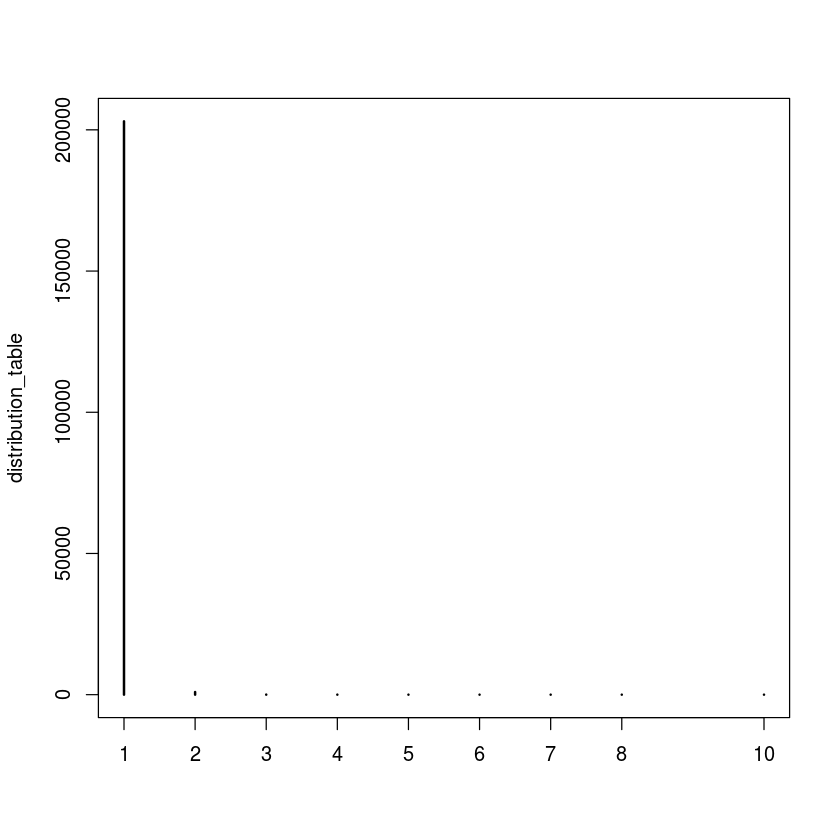

In [9]:
creator_table=table(Kickstarter$creator)
distribution_table=table(as.numeric(creator_table))
print(distribution_table)
plot(distribution_table)

As we can see almost all of the projects are from different persons but there is one person with 10 active projects, we could then check out this person projects

In [10]:
projects=creator_table[which(as.numeric(creator_table)==10)] 
projects=names(projects)

[1] 10 37
 [1] 0 0 0 0 0 0 0 0 0 0


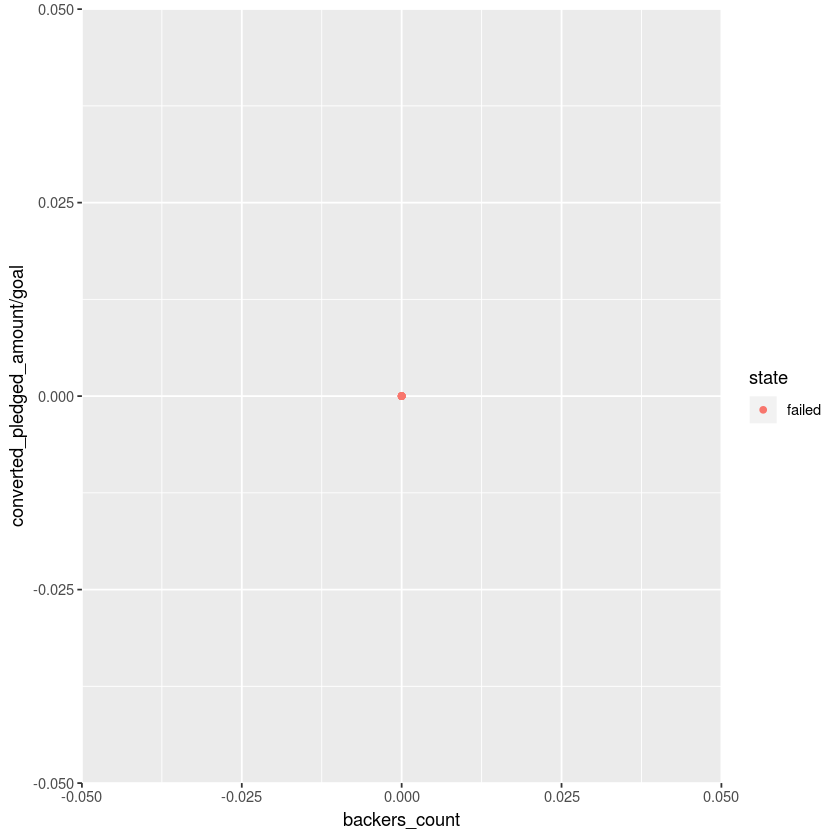

In [11]:
subset=Kickstarter[which(Kickstarter$creator==projects),]
print(dim(subset))
print(subset$backers_count)
ggplot(data=subset) +geom_point(aes(x=backers_count,y=converted_pledged_amount/goal  ,color=state)) 

Ironically looks like all these projects have failed with no backers
Next we could explore how to best predict the country in this dataset by using the cleanerR package

In [12]:
goal=which(names(Kickstarter)=="country")
BestSet=best_vector(df=data.frame(Kickstarter),goal =goal,maxi = 2,repetitions = nrow(Kickstarter),trigger = 1 )
cat("The best set to predict country is",names(Kickstarter)[BestSet],"It predicts with accuracy",MeanAccuracy(df = Kickstarter,goal = goal,VECTORS = BestSet),"\n")
cat("The worst case scenario the prediction would be",WorstAccuracy(df=Kickstarter,goal = goal,VECTORS = BestSet))

[1] 1
[1] 2
The best set to predict country is currency It predicts with accuracy 0.9636722 
The worst case scenario the prediction would be 0.1625827

We can see the MeanAccuracy is quite high, but the worst accuracy not so much lets plot a graph of currency vs country to find out why

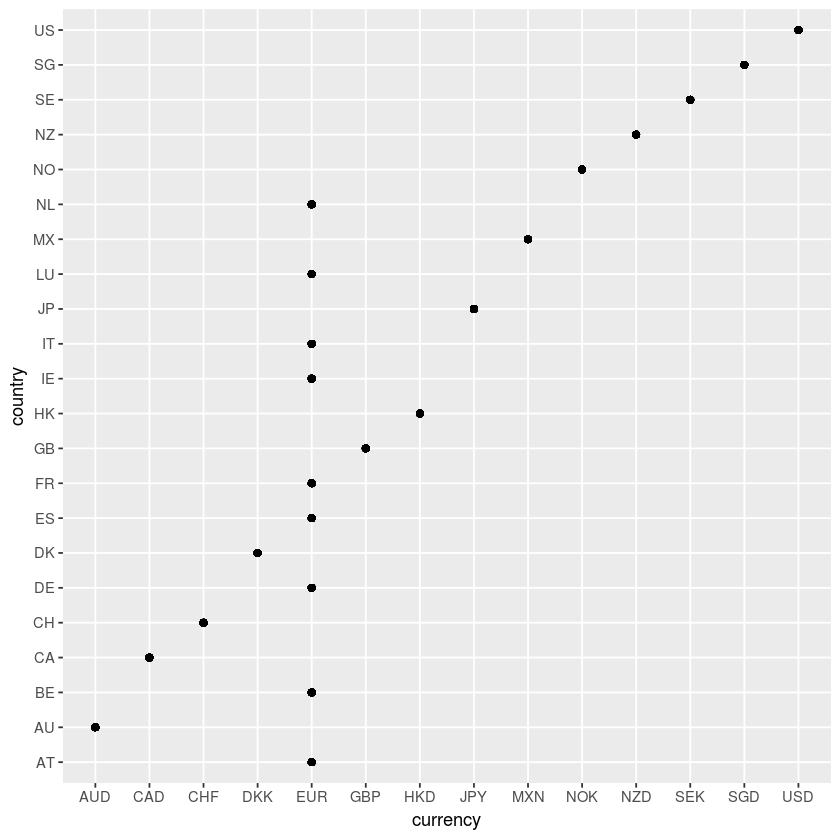

In [13]:
ggplot(data=Kickstarter) +geom_point(aes(x=currency,y=country  ) ) 

Oh now its easy to see that since all countries of the European Union share the same currency it cannot be used to predict then, but then what could? lets subset the data from the EU and check it

In [14]:
Europe=Kickstarter[which(Kickstarter$currency=="EUR"),]
BestSet=best_vector(df=data.frame(Europe),goal =goal,maxi = 2,repetitions = nrow(Europe),trigger = 1 )
cat("The best set to predict country is",names(Europe)[BestSet],"It predicts with accuracy",MeanAccuracy(df = Europe,goal = goal,VECTORS = BestSet),"\n")
cat("The worst case scenario the prediction would be",WorstAccuracy(df=Europe,goal = goal,VECTORS = BestSet))

[1] 1
[1] 2
The best set to predict country is currency It predicts with accuracy 0.1625827 
The worst case scenario the prediction would be 0.1625827

And checking the graphs

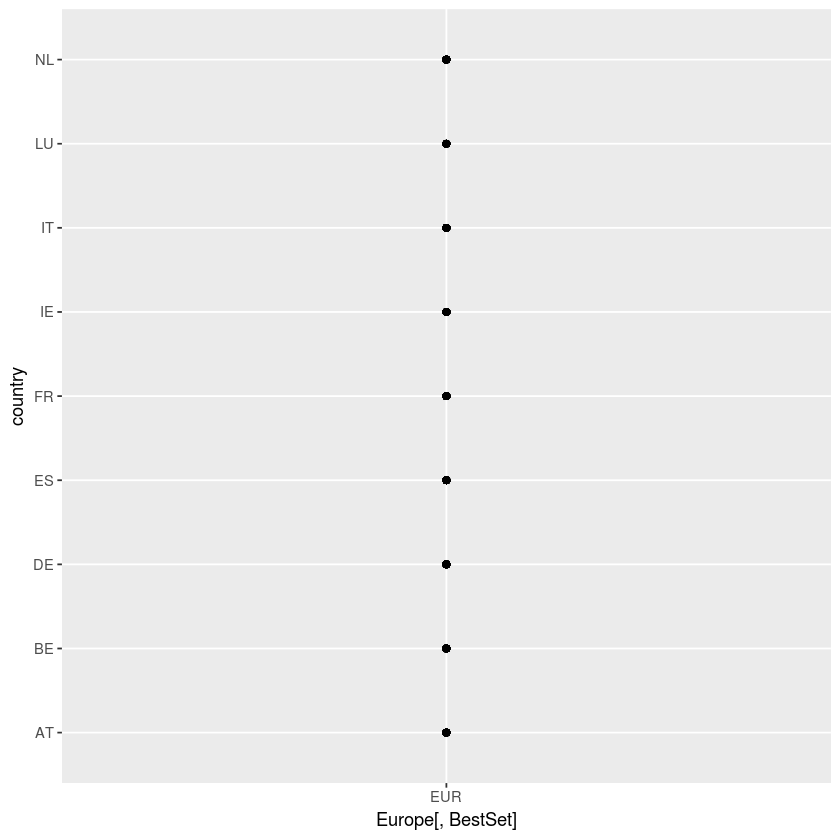

In [17]:
Europe=data.frame(Europe)
ggplot(data=Europe) +geom_point(aes(x=Europe[,BestSet],y=country  ) ) 

In conclusion this dataset does not offer enough data for us to be able to predict correctly countries of the european union, we would need more data for that